# Project3: Data Representations and Clustering
-   505851728 Yang-Shan Chen
-   005627440 Chih-En Lin
-   505297814 Rikako Hatoya

In [ ]:
from matplotlib import path
from google.colab import drive
drive.mount('/content/drive')
import sys    
import os
path_to_module = '/content/drive/MyDrive/Synthetic_Movie_Lens/'
sys.path.append(path_to_module)
os.chdir(path_to_module)

Mounted at /content/drive


In [ ]:
!pip install surprise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
movies = pd.read_csv('./movies.csv')
ratings = pd.read_csv('./ratings.csv')
testratings = pd.read_csv('./testratings.csv')

     |████████████████████████████████| 11.8 MB 7.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630199 sha256=9a43bb06753ba5b2082eaababf83578e60043148e28522aa2f183f2ebc764d10
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


# Question 1

A: Sparsity of Dataset

In [ ]:
print("Sparsity: ", ratings.rating.shape[0]/(ratings.userId.unique().shape[0]*ratings.movieId.unique().shape[0]))

Sparsity:  0.016999683055613623


B: Histogram of Rating Values Frequency

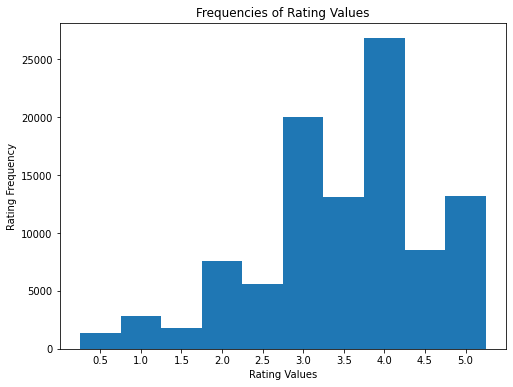

In [ ]:
data=ratings['rating']
plt.figure(figsize=(8,6))
plt.title("Frequencies of Rating Values")
plt.xlabel("Rating Values")
plt.ylabel("Rating Frequency")
plt.xticks(np.arange(0.5,5.5,0.5))
plt.hist(data, bins=np.arange(0.25, 5.75, 0.5))
plt.show()

C: Distribution of number of ratings for each movie

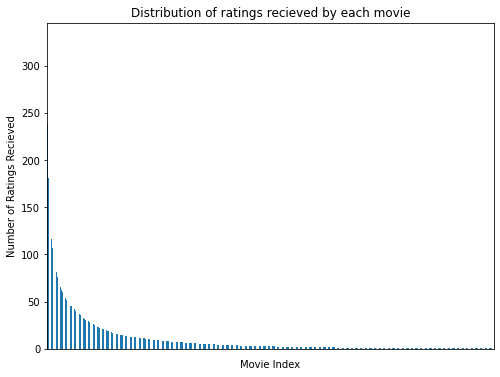

In [ ]:
ratings['movieId'].value_counts().plot(kind='bar', figsize=(8,6))
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.title("Distribution of ratings recieved by each movie")
plt.xlabel("Movie Index")
plt.ylabel("Number of Ratings Recieved")
plt.tick_params(bottom=False)
plt.show()

D: Distribution of ratings among users

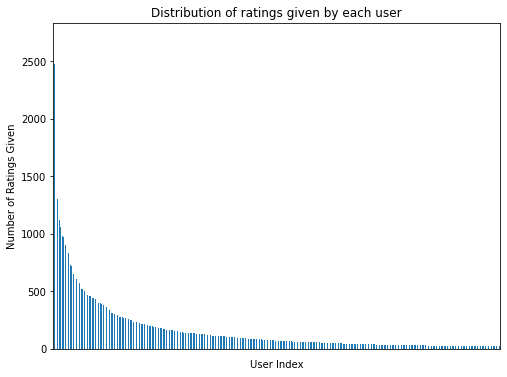

In [ ]:
ratings['userId'].value_counts().plot(kind='bar', figsize=(8,6))
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.title("Distribution of ratings given by each user")
plt.xlabel("User Index")
plt.ylabel("Number of Ratings Given")
plt.tick_params(bottom=False)
plt.show()

**E: Salient Features of Distributions**

Both distributions of number of ratings amongst movies and users both display an exponential decay graph. This indicates the signicant difference in the amount of ratings between popular and un-popular movies, as well as the difference in the number of ratings given by frequent users in comparison to less active users. This imbalance implies that the given datasets are sparse and so in the recommendation process, it is ideal to separate the given movie dataset into smaller subsets consisting of popular movies, un-popular movies, and high variance movies. 

F: Variance of Rating Values

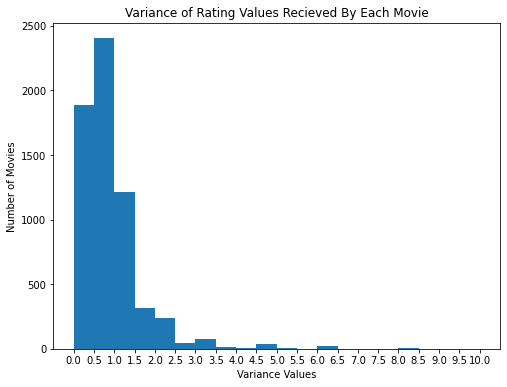

In [ ]:
from statistics import variance 
grouped_ratings = ratings.groupby("movieId")
grouped_lists = grouped_ratings["rating"].apply(list)
grouped_lists = grouped_lists.reset_index()

variance_list=[]
for row in range(len(grouped_lists.index)):
  try:
    variance_list.append(variance(grouped_lists.iloc[row]["rating"]))
  except:
    pass

plt.figure(figsize=(8,6))
plt.hist(variance_list, bins=np.arange(min(variance_list), max(variance_list), 0.5))
plt.xticks(np.arange(min(variance_list), max(variance_list), 0.5))
plt.title("Variance of Rating Values Recieved By Each Movie")
plt.xlabel("Variance Values")
plt.ylabel("Number of Movies")
plt.show()

The above histogram indicating frequency of variance values show that the most frequent variance (mode) is approximately 0.5-1.0, with the neighboring ranges 0.0-1.5 to be the next frequent values. After variance values surpass 1.5, the frequency count significantly declines, however, some counts can be observed in 8.0-8.5 at the highest.

# Question 2

$\mu_u=\frac{\sum\limits_{k\in I_u}r_{uk}}{|I_u|}$

$I_u\cap I_v$ is the set of item indices for which ratings have been specified by user $u$ and $v$. $I_u\cap I_v$ can be $\emptyset$. Actually, it's likely to be empty set since matrix $R$ is sparse.

# Question 3

In mathematical interpretation, it's a weighted linear prediction model and we shift all data points to make the mean is equal to 0. We did this since everyone has different behaviors on rating, and we remove the bias for each person to make the model more accurate.

# Question 4

In [ ]:
from surprise import Dataset
from surprise import Reader
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

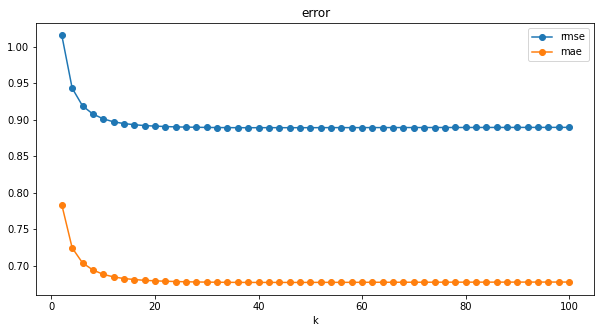

In [ ]:
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import GridSearchCV

param_grid = {'k': [i for i in range(2, 101, 2)],
        'sim_options': {'name': ['pearson']}, 'verbose':[False]}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=10)

gs.fit(data)

plt.title('error')
plt.plot([i for i in range(2, 101, 2)], gs.cv_results['mean_test_rmse'], '-o', label='rmse')
plt.plot([i for i in range(2, 101, 2)], gs.cv_results['mean_test_mae'], '-o', label='mae')
plt.xlabel('k')
plt.legend(loc='upper right')
plt.gcf().set_size_inches(10, 5)
plt.show()

# Question 5

By the figure above, minimum k = 12

In [ ]:
print('average RMSE: {}'.format(gs.cv_results['mean_test_rmse'][5]))
print('average MAE: {}'.format(gs.cv_results['mean_test_mae'][5]))

average RMSE: 0.8971544329996245
average MAE: 0.684770502109288


# Question 6

In [ ]:
from collections import defaultdict

#Popular/Unpopular movie trimming
m = np.asarray(ratings['movieId'])
c = np.bincount(m)
p_set = set(np.argwhere(c>2).flatten()) #id popular
up_set = set(np.argwhere(c<=2).flatten()) #id unpopular

#High variance movie trimming
h_set = set(np.argwhere(c<5).flatten())
y = defaultdict(list)
for row in range(ratings.shape[0]):
  if ratings.iat[row, 2] not in h_set:
    y[ratings.iat[row, 2]].append(ratings.iat[row, 3])

for id in y:
  if np.var(np.array(y[id])) < 2:
    h_set.add(id) #id high-variance

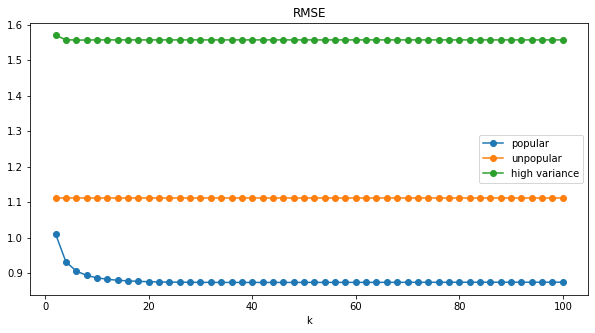

In [ ]:
from surprise import accuracy
from surprise.model_selection import KFold

kf = KFold(n_splits=10, random_state=0)
p, u, hv = [], [], []
for k in range(2, 101, 2):
  algo = KNNWithMeans(k=k, sim_options={'name': 'pearson'}, verbose=False)
  err_p = err_u = err_h = 0
  for train, test in kf.split(data):
    algo.fit(train)
    predictions = algo.test(test)
    pred_p, pred_u, pred_h = [], [], []
    for pred in predictions:
      if pred[1] in up_set:
        pred_u.append(pred)
      else:
        pred_p.append(pred)
      if pred[1] not in h_set:
        pred_h.append(pred)
    err_p += accuracy.rmse(pred_p, verbose=False)
    err_u += accuracy.rmse(pred_u, verbose=False)
    err_h += accuracy.rmse(pred_h, verbose=False)
  p.append(err_p/10)
  u.append(err_u/10)
  hv.append(err_h/10)

plt.title('RMSE')
plt.plot([i for i in range(2, 101, 2)], p, '-o', label='popular')
plt.plot([i for i in range(2, 101, 2)], u, '-o', label='unpopular')
plt.plot([i for i in range(2, 101, 2)], hv, '-o', label='high variance')
plt.xlabel('k')
plt.legend(loc='center right')
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
print('Popular movie trimming minimum average RMSE: {}'.format(min(p)))
print('Unpopular movie trimming minimum average RMSE: {}'.format(min(u)))
print('High variance movie trimming minimum average RMSE: {}'.format(min(hv)))

Popular movie trimming minimum average RMSE: 0.8740884636481674
Unpopular movie trimming minimum average RMSE: 1.1126487531841083
High variance movie trimming minimum average RMSE: 1.5568002416183464


In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve

train, test = train_test_split(data, test_size=0.1)

algo_p = KNNWithMeans(k=2 * (p.index(min(p))+1), sim_options={'name': 'pearson'}, verbose=False)
algo_p.fit(train)
algo_u = KNNWithMeans(k=2 * (u.index(min(u))+1), sim_options={'name': 'pearson'}, verbose=False)
algo_u.fit(train)
algo_h = KNNWithMeans(k=2 * (hv.index(min(hv))+1), sim_options={'name': 'pearson'}, verbose=False)
algo_h.fit(train)

In [ ]:
def extract(algo, txt):
  predictions = algo.test(test)
  pred = []
  for p in predictions:
    if txt[0] == 'p' and p[1] not in up_set:
      pred.append(p)
    elif txt[0] == 'u' and p[1] in up_set:
      pred.append(p)
    elif txt[0] == 'h' and p[1] not in h_set:
      pred.append(p)
  est, r = [], []
  for p in pred:
    r.append(p[2])
    est.append(p[3])
  est = np.asarray(est)
  r = np.asarray(r)
  return (est, r)

def plot_roc_curve(fpr, tpr, th):
  plt.plot(fpr, tpr, '-', label='threshold='+str(th))
  plt.xlabel('fpr')
  plt.ylabel('tpr')

def cal_auc(fpr, tpr):
  auc = 0
  for i in range(len(fpr)-1):
    auc += (tpr[i] + tpr[i+1]) * (fpr[i+1] - fpr[i]) / 2
  return auc

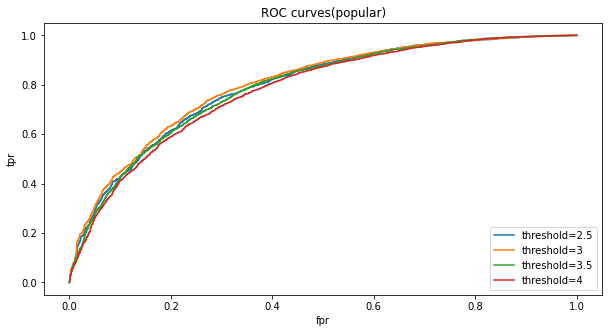

AUC value(popular, threshold=2.5): 0.7926869778659574
AUC value(popular, threshold=3): 0.8012042888118825
AUC value(popular, threshold=3.5): 0.7890771661311192
AUC value(popular, threshold=4): 0.7791142632431854


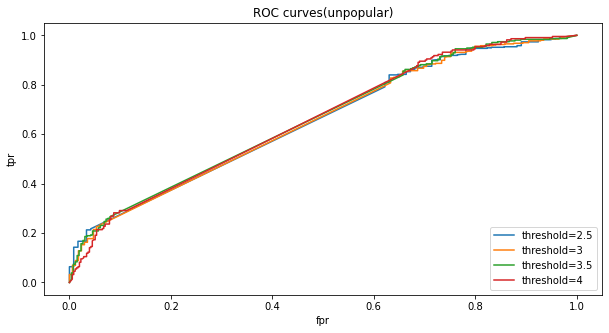

AUC value(unpopular, threshold=2.5): 0.6504496535456288
AUC value(unpopular, threshold=3): 0.6496997697262948
AUC value(unpopular, threshold=3.5): 0.6578434240031199
AUC value(unpopular, threshold=4): 0.6561523687580025


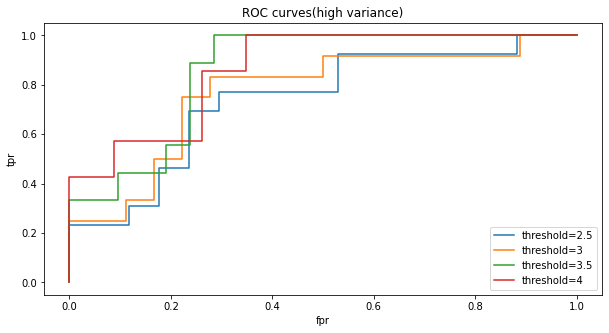

AUC value(high variance, threshold=2.5): 0.7375565610859729
AUC value(high variance, threshold=3): 0.7685185185185185
AUC value(high variance, threshold=3.5): 0.8571428571428572
AUC value(high variance, threshold=4): 0.8633540372670807


In [ ]:
thres = [2.5, 3, 3.5, 4]
for algo, txt in [(algo_p, 'popular'), (algo_u, 'unpopular'), (algo_h, 'high variance')]:
  auc = []
  for th in thres:
    est, r = extract(algo, txt)
    r_ = np.where(r<th, 0, 1)
    fpr, tpr, thresholds = roc_curve(r_, est, pos_label=1)
    plt.title('ROC curves('+txt+')')
    plot_roc_curve(fpr, tpr, th)
    auc.append(cal_auc(fpr, tpr))
  plt.legend(loc='lower right')
  plt.gcf().set_size_inches(10, 5)
  plt.show()
  for i, t in enumerate(auc):
    print('AUC value('+txt+', threshold='+str(thres[i])+'): {}'.format(auc[i]))


# Question 7

- The optimization problem given by equation 5 is not jointly convex because of the W matrix and the existence of multiple local minima in the objective function gradient plane. Using the product of U and V to predict ratings doesn't satisfy the property of convexity as the objective function is permutation and rotation invariant.
- For fixed U, the least-squares formulation (without regularization) of the objective function is:
<center>$\min\limits_V\sum\limits_{i=1}^{m}\sum\limits_{j=1}^{n}W_{ij}(r_{ij}-(UV^{T})_{ij})^{2}$</center>
<center>$V=(UU^{T})^{-1}UR$</center>
<center>where $R$ is the ratings matrix</center>

# Question 8

- 8-A

In [ ]:
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

In [ ]:
rmse_NMF = []
mae_NMF = []
ks = np.arange(2, 52, 2)

for k in ks:
    print("NMF with k = {} ... ".format(k), end = '')
    cv = cross_validate(NMF(n_factors=k, verbose=False), measures=['rmse', 'mae'], data=data, cv=10, n_jobs=-1)   
    rmse_NMF.append(np.mean(cv['test_rmse']))
    mae_NMF.append(np.mean(cv['test_mae']))
    print("Done")

NMF with k = 2 ... Done
NMF with k = 4 ... Done
NMF with k = 6 ... Done
NMF with k = 8 ... Done
NMF with k = 10 ... Done
NMF with k = 12 ... Done
NMF with k = 14 ... Done
NMF with k = 16 ... Done
NMF with k = 18 ... Done
NMF with k = 20 ... Done
NMF with k = 22 ... Done
NMF with k = 24 ... Done
NMF with k = 26 ... Done
NMF with k = 28 ... Done
NMF with k = 30 ... Done
NMF with k = 32 ... Done
NMF with k = 34 ... Done
NMF with k = 36 ... Done
NMF with k = 38 ... Done
NMF with k = 40 ... Done
NMF with k = 42 ... Done
NMF with k = 44 ... Done
NMF with k = 46 ... Done
NMF with k = 48 ... Done
NMF with k = 50 ... Done


- 8-B

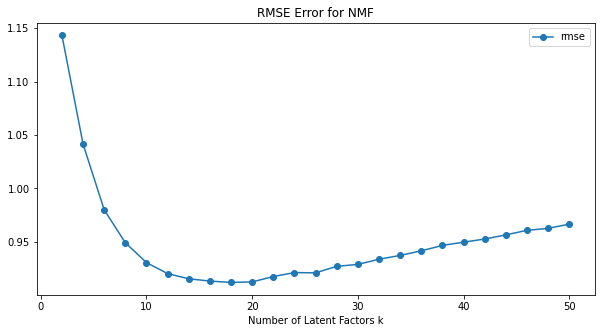

In [ ]:
plt.title('RMSE Error for NMF')
plt.plot(ks, rmse_NMF, '-o', label='rmse')
plt.xlabel('Number of Latent Factors k')
plt.legend(loc='best')
plt.gcf().set_size_inches(10, 5)
plt.show()

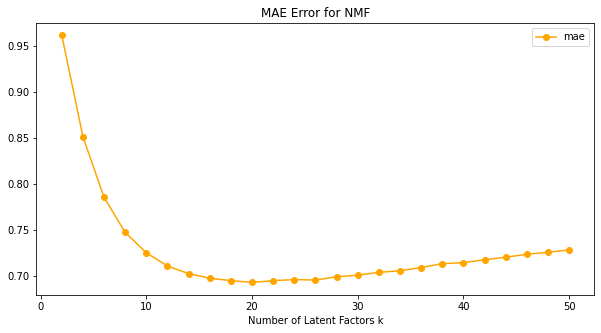

In [ ]:
plt.title('MAE Error for NMF')
plt.plot(ks, mae_NMF, '-o', label='mae', color='orange')
plt.xlabel('Number of Latent Factors k')
plt.legend(loc='best')
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
min_rmse_NMF = min(rmse_NMF)
min_mae_NMF = min(mae_NMF)

min_k_rmse_NMF = ks[rmse_NMF.index(min_rmse_NMF)]
min_k_mae_NMF = ks[mae_NMF.index(min_mae_NMF)]

print("Minimum Average RMSE for NMF: {}, the value of k: {}".format(min_rmse_NMF, min_k_rmse_NMF))
print("Minimum Average MAE for NMF: {}, the value of k: {}".format(min_mae_NMF, min_k_mae_NMF))

Minimum Average RMSE for NMF: 0.9118343760443274, the value of k: 18
Minimum Average MAE for NMF: 0.6930403985292423, the value of k: 20


- Q: Is the optimal number of latent factors same as the number of movie genres?
- A: The optimal number of latent factors of minimum average RMSE is k = 18, while the optimal number of latent factors of minimum average MAE is k = 20. There are 19 movie genres in the dataset. Thus, the optimal number of latent factors is very close to the number of movie genres. And, the average of 18 and 20 is 19, which is exactly same as the number of movie genres.

- 8-C

In [ ]:
kf = KFold(n_splits=10, random_state=0)
rmse_NMF_p = []
rmse_NMF_u = []
rmse_NMF_h = []
ks = np.arange(2, 52, 2)

for k in ks:
  print("NMF with k = {} ... ".format(k), end = '')
  algo = NMF(n_factors=k, verbose=False)
  err_p, err_u, err_h = [], [], []
  for train, test in kf.split(data):
    algo.fit(train)
    pred_p, pred_u, pred_h = [], [], []
    predictions = algo.test(test)
    for pred in predictions:
      if pred[1] in p_set:
        pred_p.append(pred)
      if pred[1] in up_set:
        pred_u.append(pred) 
      if pred[1] not in h_set:
        pred_h.append(pred)
    err_p.append(accuracy.rmse(pred_p, verbose=False))
    err_u.append(accuracy.rmse(pred_u, verbose=False))
    err_h.append(accuracy.rmse(pred_h, verbose=False))
  rmse_NMF_p.append(np.mean(err_p))
  rmse_NMF_u.append(np.mean(err_u))
  rmse_NMF_h.append(np.mean(err_h))
  print("Done")

NMF with k = 2 ... Done
NMF with k = 4 ... Done
NMF with k = 6 ... Done
NMF with k = 8 ... Done
NMF with k = 10 ... Done
NMF with k = 12 ... Done
NMF with k = 14 ... Done
NMF with k = 16 ... Done
NMF with k = 18 ... Done
NMF with k = 20 ... Done
NMF with k = 22 ... Done
NMF with k = 24 ... Done
NMF with k = 26 ... Done
NMF with k = 28 ... Done
NMF with k = 30 ... Done
NMF with k = 32 ... Done
NMF with k = 34 ... Done
NMF with k = 36 ... Done
NMF with k = 38 ... Done
NMF with k = 40 ... Done
NMF with k = 42 ... Done
NMF with k = 44 ... Done
NMF with k = 46 ... Done
NMF with k = 48 ... Done
NMF with k = 50 ... Done


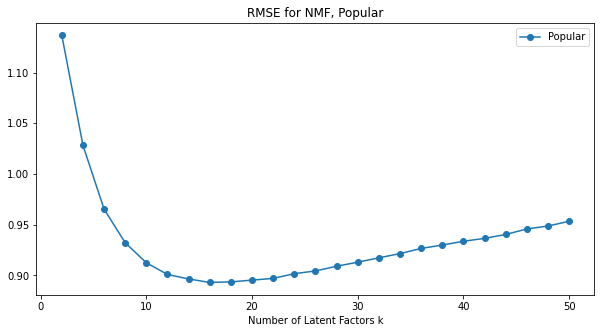

In [ ]:
plt.title('RMSE for NMF, Popular')
plt.plot(ks, rmse_NMF_p, '-o', label='Popular')
plt.xlabel('Number of Latent Factors k')
plt.legend(loc='best')
plt.gcf().set_size_inches(10, 5)
plt.show()

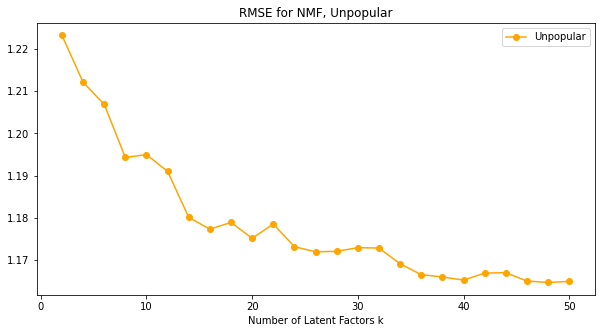

In [ ]:
plt.title('RMSE for NMF, Unpopular')
plt.plot(ks, rmse_NMF_u, '-o', label='Unpopular', color='orange')
plt.xlabel('Number of Latent Factors k')
plt.legend(loc='best')
plt.gcf().set_size_inches(10, 5)
plt.show()

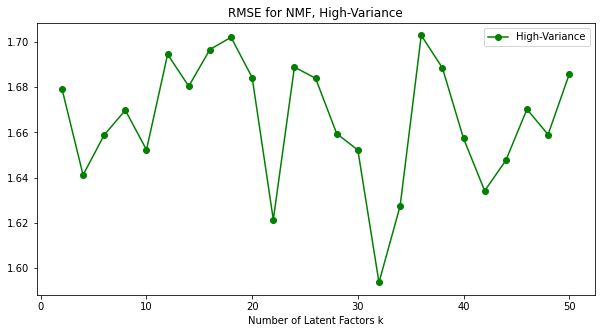

In [ ]:
plt.title('RMSE for NMF, High-Variance')
plt.plot(ks, rmse_NMF_h, '-o', label='High-Variance', color='green')
plt.xlabel('Number of Latent Factors k')
plt.legend(loc='best')
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
min_rmse_NMF_p = min(rmse_NMF_p)
min_rmse_NMF_u = min(rmse_NMF_u)
min_rmse_NMF_h = min(rmse_NMF_h)

min_k_rmse_NMF_p = ks[rmse_NMF_p.index(min_rmse_NMF_p)]
min_k_rmse_NMF_u = ks[rmse_NMF_u.index(min_rmse_NMF_u)]
min_k_rmse_NMF_h = ks[rmse_NMF_h.index(min_rmse_NMF_h)]

print("Minimum Average RMSE for NMF, Popular Movie Trimming: {}, the value of k: {}".format(min_rmse_NMF_p, min_k_rmse_NMF_p))
print("Minimum Average RMSE for NMF, Unpopular Movie Trimming: {}, the value of k: {}".format(min_rmse_NMF_u, min_k_rmse_NMF_u))
print("Minimum Average RMSE for NMF, High-Variance Movie Trimming: {}, the value of k: {}".format(min_rmse_NMF_h, min_k_rmse_NMF_h))

Minimum Average RMSE for NMF, Popular Movie Trimming: 0.8929580931261363, the value of k: 16
Minimum Average RMSE for NMF, Unpopular Movie Trimming: 1.1647127044821681, the value of k: 48
Minimum Average RMSE for NMF, High-Variance Movie Trimming: 1.593554782004066, the value of k: 32


- Plot the ROC curves

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
thres = [2.5, 3, 3.5, 4]
train, test = train_test_split(data, test_size=0.1)
algo = NMF(n_factors=min_k_rmse_NMF, verbose=False).fit(train)

In [ ]:
predictions = algo.test(test)
pred = []

est, r = [], []
for p in predictions:
    r.append(p[2])
    est.append(p[3])
est = np.asarray(est)
r = np.asarray(r)

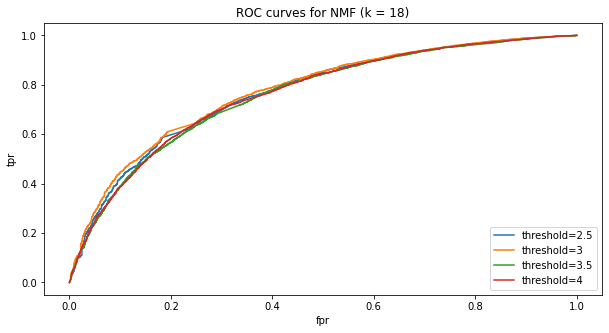

AUC value (threshold=2.5): 0.7683207209616605
AUC value (threshold=3): 0.7760321671182314
AUC value (threshold=3.5): 0.759691071114845
AUC value (threshold=4): 0.7625954680875254


In [ ]:
auc_NMF = []

fpr, tpr = [], []
for th in thres:
    r_ = np.where(r<th, 0, 1)
    fpr, tpr, thresholds = roc_curve(r_, est, pos_label=1)
    plt.title('ROC curves for NMF (k = '+str(min_k_rmse_NMF)+')')
    plot_roc_curve(fpr, tpr, th)
    auc_NMF.append(auc(fpr, tpr))

plt.legend(loc='lower right')
plt.gcf().set_size_inches(10, 5)
plt.show()
for i, t in enumerate(auc_NMF):
    print('AUC value (threshold='+str(thres[i])+'): {}'.format(auc_NMF[i]))

# Question 9

In [ ]:
# genre = pd.read_csv('./Synthetic_Movie_Lens/movies.csv', usecols=['movieId', 'title', 'genres'])
genre = pd.read_csv('./movies.csv', usecols=['movieId', 'title', 'genres'])
train, test = train_test_split(data, test_size=0.1)
algo = NMF(n_factors=20, verbose=False)
algo.fit(train).test(test)
U = algo.pu
V = algo.qi

In [ ]:
cols = [0, 2, 4, 6, 8, 11, 15, 19]
for col in cols:
    print("Column Index of V: {}".format(col))
    selected_col = V[:, col]
    sorted_col = np.argsort(selected_col)[::-1]
    for i in sorted_col[0 : 10]:
        print(genre['genres'][i])
    print("")

Column Index of V: 0
Drama|Horror|Mystery|Thriller
Drama|Thriller
Crime|Drama|Mystery|Thriller
Drama
Action|Comedy|Crime
Drama
Drama
Crime|Drama
Comedy
Comedy

Column Index of V: 2
Drama|Mystery|Western
Comedy
Comedy
Comedy
Action|Crime|Thriller
Action|Adventure|Sci-Fi|Thriller
Drama|Romance
Drama|Romance
Documentary
Comedy|Crime|Mystery

Column Index of V: 4
Drama|Thriller
Adventure|Drama
Horror|Western
Crime|Film-Noir
Comedy|Drama|Romance
Drama
Comedy|Romance
Drama
Drama
Drama|Romance

Column Index of V: 6
Drama|Romance
Comedy
Drama|War
Horror|Sci-Fi
Action|Adventure|Crime|Horror|Thriller
Action|Comedy|Thriller
Comedy|Drama
Comedy|Fantasy|Romance|Sci-Fi
Drama|Horror|Thriller
Crime|Drama

Column Index of V: 8
Crime|Drama
Crime|Drama|Romance
Drama|Fantasy|Sci-Fi
Drama
Adventure|Children|Fantasy
Adventure|Comedy|Musical
Comedy|Drama
Animation|Children|Comedy
Comedy|Drama|Romance
Adventure

Column Index of V: 11
Comedy|Musical|Romance|Western
Comedy|Horror
Comedy|Horror
Comedy
Comedy|Dra

- Q: Do the top 10 movies belong to a particular or a small collection of genre?
- A: As shown in the genre list, we can see that the top 10 movies belong to a small collection of genres.
- Q: Is there a connection between the latent factors and the movie genres?
- A: Each latent factor tends to group movies from small particular groups of genres. For example, latent factor 19 have most movies from the comedy and drama, latent factor 5 have movies from the drama|romance and latent factor 7 have movies from the action, crime and horror. Besides, as the number of latent factors increases, the number of distinct movie genres tends to decrease. It is because the movie genres are clustered more closely together.

# Question 10

- 10-A

In [ ]:
rmse_MF = []
mae_MF = []
ks = np.arange(2, 52, 2)

for k in ks:
    print("MF with k = {} ... ".format(k), end = '')
    cv = cross_validate(SVD(n_factors=k, verbose=False), measures=['rmse', 'mae'], data=data, cv=10, n_jobs=-1)   
    rmse_MF.append(np.mean(cv['test_rmse']))
    mae_MF.append(np.mean(cv['test_mae']))
    print("Done")

MF with k = 2 ... Done
MF with k = 4 ... Done
MF with k = 6 ... Done
MF with k = 8 ... Done
MF with k = 10 ... Done
MF with k = 12 ... Done
MF with k = 14 ... Done
MF with k = 16 ... Done
MF with k = 18 ... Done
MF with k = 20 ... Done
MF with k = 22 ... Done
MF with k = 24 ... Done
MF with k = 26 ... Done
MF with k = 28 ... Done
MF with k = 30 ... Done
MF with k = 32 ... Done
MF with k = 34 ... Done
MF with k = 36 ... Done
MF with k = 38 ... Done
MF with k = 40 ... Done
MF with k = 42 ... Done
MF with k = 44 ... Done
MF with k = 46 ... Done
MF with k = 48 ... Done
MF with k = 50 ... Done


- 10-B

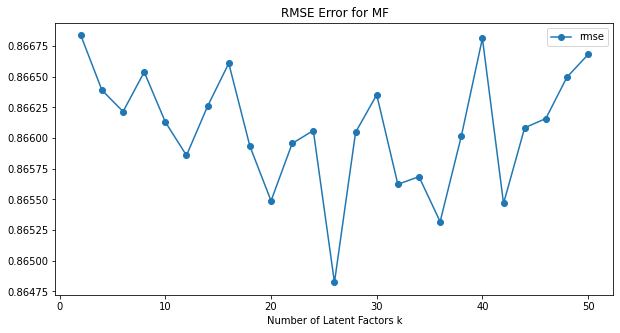

In [ ]:
plt.title('RMSE Error for MF')
plt.plot(ks, rmse_MF, '-o', label='rmse')
plt.xlabel('Number of Latent Factors k')
plt.legend(loc='best')
plt.gcf().set_size_inches(10, 5)
plt.show()

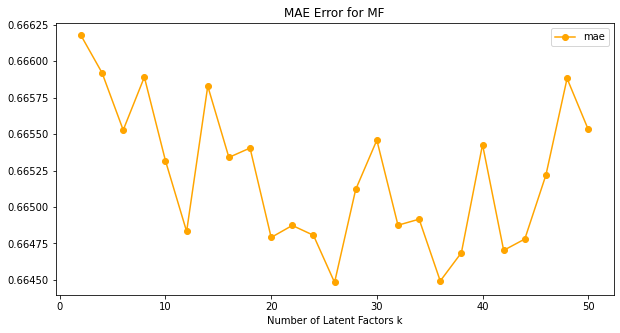

In [ ]:
plt.title('MAE Error for MF')
plt.plot(ks, mae_MF, '-o', label='mae', color='orange')
plt.xlabel('Number of Latent Factors k')
plt.legend(loc='best')
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
min_rmse_MF = min(rmse_MF)
min_mae_MF = min(mae_MF)

min_k_rmse_MF = ks[rmse_MF.index(min_rmse_MF)]
min_k_mae_MF = ks[mae_MF.index(min_mae_MF)]

print("Minimum Average RMSE for MF: {}, the value of k: {}".format(min_rmse_MF, min_k_rmse_MF))
print("Minimum Average MAE for MF: {}, the value of k: {}".format(min_mae_MF, min_k_mae_MF))

Minimum Average RMSE for MF: 0.8648223413484495, the value of k: 26
Minimum Average MAE for MF: 0.6644827857479145, the value of k: 26


- Q: Is the optimal number of latent factors same as the number of movie genres?
- A: The optimal number of latent factors of minimum average RMSE is k = 26, while the optimal number of latent factors of minimum average MAE is k = 26. There are 19 movie genres in the dataset. So, k of RMSE and MAE are close to the optimal number of latent factors. However, for MF, both RSME and MAE do not change much as k changes. When k is close to the number of movie genres, RSME and MAE are relatively low and very close to the minimum average value.

- 10-C

In [ ]:
kf = KFold(n_splits=10, random_state=0)
rmse_MF_p = []
rmse_MF_u = []
rmse_MF_h = []
ks = np.arange(2, 52, 2)

for k in ks:
    print("MF with k = {} ... ".format(k), end = '')
    algo = SVD(n_factors=k, verbose=False)
    err_p, err_u, err_h = [], [], []
    for train, test in kf.split(data):
        algo.fit(train)
        pred_p, pred_u, pred_h = [], [], []
        predictions = algo.test(test)
        for pred in predictions:
            if pred[1] in p_set:
                pred_p.append(pred)
            if pred[1] in up_set:
                pred_u.append(pred) 
            if pred[1] not in h_set:
                pred_h.append(pred)
        
        err_p.append(accuracy.rmse(pred_p, verbose=False))
        err_u.append(accuracy.rmse(pred_u, verbose=False))
        err_h.append(accuracy.rmse(pred_h, verbose=False))
    rmse_MF_p.append(np.mean(err_p))
    rmse_MF_u.append(np.mean(err_u))
    rmse_MF_h.append(np.mean(err_h))
    print("Done")

MF with k = 2 ... Done
MF with k = 4 ... Done
MF with k = 6 ... Done
MF with k = 8 ... Done
MF with k = 10 ... Done
MF with k = 12 ... Done
MF with k = 14 ... Done
MF with k = 16 ... Done
MF with k = 18 ... Done
MF with k = 20 ... Done
MF with k = 22 ... Done
MF with k = 24 ... Done
MF with k = 26 ... Done
MF with k = 28 ... Done
MF with k = 30 ... Done
MF with k = 32 ... Done
MF with k = 34 ... Done
MF with k = 36 ... Done
MF with k = 38 ... Done
MF with k = 40 ... Done
MF with k = 42 ... Done
MF with k = 44 ... Done
MF with k = 46 ... Done
MF with k = 48 ... Done
MF with k = 50 ... Done


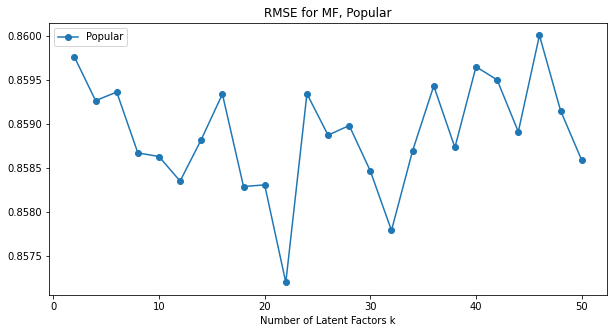

In [ ]:
plt.title('RMSE for MF, Popular')
plt.plot(ks, rmse_MF_p, '-o', label='Popular')
plt.xlabel('Number of Latent Factors k')
plt.legend(loc='best')
plt.gcf().set_size_inches(10, 5)
plt.show()

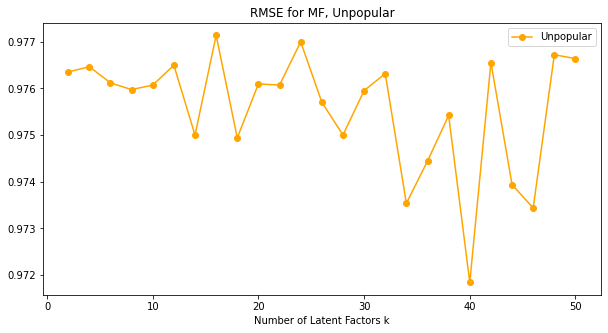

In [ ]:
plt.title('RMSE for MF, Unpopular')
plt.plot(ks, rmse_MF_u, '-o', label='Unpopular', color='orange')
plt.xlabel('Number of Latent Factors k')
plt.legend(loc='best')
plt.gcf().set_size_inches(10, 5)
plt.show()

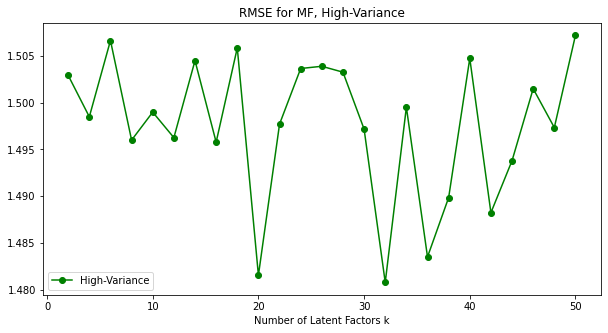

In [ ]:
plt.title('RMSE for MF, High-Variance')
plt.plot(ks, rmse_MF_h, '-o', label='High-Variance', color='green')
plt.xlabel('Number of Latent Factors k')
plt.legend(loc='best')
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
min_rmse_MF_p = min(rmse_MF_p)
min_rmse_MF_u = min(rmse_MF_u)
min_rmse_MF_h = min(rmse_MF_h)

min_k_rmse_MF_p = ks[rmse_MF_p.index(min_rmse_MF_p)]
min_k_rmse_MF_u = ks[rmse_MF_u.index(min_rmse_MF_u)]
min_k_rmse_MF_h = ks[rmse_MF_h.index(min_rmse_MF_h)]

print("Minimum Average RMSE for MF, Popular Movie Trimming: {}, the value of k: {}".format(min_rmse_MF_p, min_k_rmse_MF_p))
print("Minimum Average RMSE for MF, Unpopular Movie Trimming: {}, the value of k: {}".format(min_rmse_MF_u, min_k_rmse_MF_u))
print("Minimum Average RMSE for MF, High-Variance Movie Trimming: {}, the value of k: {}".format(min_rmse_MF_h, min_k_rmse_MF_h))

Minimum Average RMSE for MF, Popular Movie Trimming: 0.857202453909151, the value of k: 22
Minimum Average RMSE for MF, Unpopular Movie Trimming: 0.9718390457665663, the value of k: 40
Minimum Average RMSE for MF, High-Variance Movie Trimming: 1.480778669257497, the value of k: 32


- Plot the ROC curves

In [ ]:
thres = [2.5, 3, 3.5, 4]
train, test = train_test_split(data, test_size=0.1)
algo = SVD(n_factors=min_k_rmse_MF, verbose=False).fit(train)

In [ ]:
predictions = algo.test(test)
pred = []

est, r = [], []
for p in predictions:
    r.append(p[2])
    est.append(p[3])
est = np.asarray(est)
r = np.asarray(r)

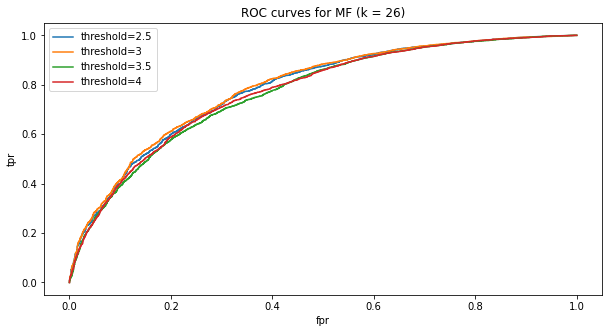

AUC value (threshold=2.5): 0.7842272500471991
AUC value (threshold=3): 0.7891740613458751
AUC value (threshold=3.5): 0.769213878921908
AUC value (threshold=4): 0.7737682441136267


In [ ]:
auc_MF = []

fpr, tpr = [], []
for th in thres:
    r_ = np.where(r<th, 0, 1)
    fpr, tpr, thresholds = roc_curve(r_, est, pos_label=1)
    plt.title('ROC curves for MF (k = '+str(min_k_rmse_MF)+')')
    plot_roc_curve(fpr, tpr, th)
    auc_MF.append(auc(fpr, tpr))

plt.legend(loc='best')
plt.gcf().set_size_inches(10, 5)
plt.show()
for i, t in enumerate(auc_MF):
    print('AUC value (threshold='+str(thres[i])+'): {}'.format(auc_MF[i]))

# Question 11

In [ ]:
###Trimming Dataset

#Add a column of variance values to original dataframe
variance_list = []
for row in range(ratings.shape[0]):
  movie = ratings.iloc[row][2]
  movieId_position = ratings.groupby(['movieId'])['rating'].var().index.to_list().index(movie)
  movieId_variance = ((ratings.groupby(['movieId'])['rating'].var()).to_list())[movieId_position]
  variance_list.append(movieId_variance)
ratings["ratingVariance"] = variance_list

#Add a column of mean ratings to original dataframe
mean_list = []
for row in range(ratings.shape[0]):
  user = ratings.iloc[row][1]
  userId_position = ratings.groupby(['userId'])['rating'].mean().index.to_list().index(user)
  userId_mean = ((ratings.groupby(['userId'])['rating'].mean()).to_list())[userId_position]
  mean_list.append(userId_mean)
ratings["ratingMean"] = mean_list

#Obtain movieId frequency counts
movieId_list = ratings["movieId"].value_counts().index.tolist()
movieId_list_count = ratings["movieId"].value_counts().tolist()

#Create Popular/Un-Popular Movie ID list
movieId_popular = []
movieId_unpopular = []
for row in range(len(movieId_list)):
  if movieId_list_count[row] > 2:
    movieId_popular.append(movieId_list[row])
  else:
    movieId_unpopular.append(movieId_list[row])

#Create High-Variance Movie ID list
highvar_movieId = []
for row in range(ratings.shape[0]):
  if ratings.iloc[row][5] >= 2:
    if movieId_list_count[movieId_list.index(int(ratings.iloc[row][2]))] >= 5:
      highvar_movieId.append(ratings.iloc[row][2])
    else:
      pass
  else:
    pass

#Re-create new dataframes with chosen movieId
ratings_popular = ratings[ratings['movieId'].isin(movieId_popular)]
ratings_unpopular = ratings[ratings['movieId'].isin(movieId_unpopular)]
ratings_highvar = ratings[ratings['movieId'].isin(highvar_movieId)]

In [ ]:
###Naive Filter
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

def naive_filter(dataset):
  true_ratings = list(dataset.rating)
  pred_ratings = list(dataset.ratingMean)
  
  kf = KFold(n_splits=10, shuffle=True)
  rmse = []
  for train_set, test_set in kf.split(dataset):
    pred = []
    true = []
    for index in test_set:
      pred.append(pred_ratings[index])
      true.append(true_ratings[index])
    rmse.append(np.sqrt(mean_squared_error(pred, true)))
  return np.mean(rmse)

In [ ]:
print('Original dataset average RMSE: {}'.format(naive_filter(ratings)))
print('Popular movie trimming average RMSE: {}'.format(naive_filter(ratings_popular)))
print('Unpopular movie trimming average RMSE: {}'.format(naive_filter(ratings_unpopular)))
print('High variance movie trimming average RMSE: {}'.format(naive_filter(ratings_highvar)))

Original dataset average RMSE: 0.9346953245674721
Popular movie trimming average RMSE: 0.9323239061774279
Unpopular movie trimming average RMSE: 0.970919260444519
High variance movie trimming average RMSE: 1.3760701430108628


# Question 12

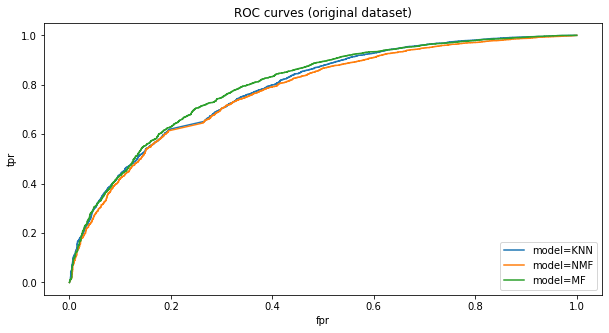

In [ ]:
###ROC curve
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
train, test = train_test_split(data, test_size=0.1)

th = 3
original = gs.cv_results['mean_test_rmse'].tolist()
k_original = 2 * (original.index(min(original))+1)
algo_list = [(KNNWithMeans(k=k_original, sim_options={'name': 'pearson'}, verbose=False), 'KNN'), (NMF(n_factors=min_k_rmse_NMF, verbose=False), 'NMF'), (SVD(n_factors=min_k_rmse_MF, verbose=False), 'MF')]

for algo, txt in algo_list:
  algo.fit(train)
  predictions = algo.test(test)
  est, r = [], []
  for p in predictions:
    r.append(p[2])
    est.append(p[3])
  est = np.asarray(est)
  r = np.asarray(r)
  r_ = np.where(r<th, 0, 1)
  fpr, tpr, thresholds = roc_curve(r_, est, pos_label=1)
  plt.plot(fpr, tpr, '-', label='model='+str(txt))

plt.title('ROC curves (original dataset)')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(10, 5)
plt.show()

The most ideal model is the one with the most area under its ROC curve (AUC.) From the above 3 ROC curves, model MF can be predicted to display the highest performance in predicting the ratings of the movies with KNN and NMF performing similarly but at a lower level than MF. 

# Question 13

Precision: The number of movies liked by the user and was recommended to the user with a size of "t" (which all had ground truth ratings,) out of the "t" movies recommended to the user.

Recall: The number of movies liked by the user and was recommended to the user with a size of "t" (which all had ground truth ratings,) out of the number of movies liked by the user.


# Question 14

In [ ]:
#make a zipped list with a list of tuples of movieId and rating for each userId
userId_list = ratings.userId.value_counts().index.to_list()
userId_ratinglist = [ [] for _ in range(len(ratings.userId.value_counts())) ]
for row in range(ratings.shape[0]):
  position = userId_list.index(int(ratings.iloc[row][1]))
  userId_ratinglist[position].append((ratings.iloc[row][2], ratings.iloc[row][3]))

userId_ratinglist_zipped = list(zip(userId_list, userId_ratinglist))

#returns list of userIds which have given atleast t ratings
def drop_user(t):
  counter = 0
  userId_chosen = []
  while counter < len(userId_ratinglist_zipped):
    if len(userId_ratinglist_zipped[counter][1]) >= t:
      userId_chosen.append(userId_ratinglist_zipped[counter][0])
    else:
      pass
    counter += 1
  return  userId_chosen
  
#K-fold
from surprise.model_selection import KFold
precision_vs_t_allmodels, recall_vs_t_allmodels = [], []
kf = KFold(n_splits=10, random_state=0)
t_list = [*range(1, 26, 1)]

algo_list = [(KNNWithMeans(k=12, sim_options={'name': 'pearson'}, verbose=False), 'KNN'), (NMF(n_factors=min_k_rmse_NMF, verbose=False), 'NMF'), (SVD(n_factors=min_k_rmse_MF, verbose=False), 'MF')]
for algo, txt in algo_list:
  precision_vs_t, recall_vs_t = [], []
  for t in t_list:
    userId_chosen_list = drop_user(t)
    userId_chosen_df = ratings[ratings['userId'].isin(userId_chosen_list)]

    data = Dataset.load_from_df(userId_chosen_df[['userId', 'movieId', 'rating']], reader)
    precision_fold, recall_fold = [], []
    for train, test in kf.split(data):
      #calculate r_ui and est for all users
      algo.fit(train)
      predictions = algo.test(test)
      data = []
      for p in predictions:
        data.append([p[0], p[2], p[3]])
      df = pd.DataFrame(np.asarray(data), columns = ['userId', 'r_ui', 'est'])
      
      #create zipped list from userId and (r_ui, est)
      userId_rec_list = df.userId.value_counts().index.to_list()
      userId_rating_rec_list = [ [] for _ in range(len(df.userId.value_counts())) ]
      for row in range(df.shape[0]):
        position = userId_rec_list.index(int(df.iloc[row][0]))
        userId_rating_rec_list[position].append((df.iloc[row][1], df.iloc[row][2]))
        
      true_predicted_zipped = list(zip(userId_rec_list, userId_rating_rec_list))

      #calculate g, s, s_and_g for each user
      precision_user, recall_user = [], []
      user_counter = 0
      while user_counter < len(true_predicted_zipped):
        g = []
        for pair in true_predicted_zipped[user_counter][1]:
          if pair[0] >= 3:
            g.append(pair)
          else:
            pass
        ranked_list = []
        for pair in true_predicted_zipped[user_counter][1]:
          ranked_list.append(pair)
        ranked_list.sort(key=lambda x:x[1], reverse=True)
        s = ranked_list[:t]
        sg = []
        for pair in s:
          if (pair[0] >= 3):
            sg.append(pair)
          else:
            pass
        if len(s) != 0:
          precision_user.append(len(sg) / len(s)) 
        if len(g) != 0:
          recall_user.append(len(sg) / len(g))
        user_counter+=1
      precision_fold.append(sum(precision_user)/len(precision_user)) 
      recall_fold.append(sum(recall_user)/len(recall_user)) 

    precision_vs_t.append(sum(precision_fold)/len(precision_fold))
    recall_vs_t.append(sum(recall_fold)/len(recall_fold))
    print("t=", t, "...Done")
  precision_vs_t_allmodels.append(precision_vs_t)
  recall_vs_t_allmodels.append(recall_vs_t)

t= 1 ...Done
t= 2 ...Done
t= 3 ...Done
t= 4 ...Done
t= 5 ...Done
t= 6 ...Done
t= 7 ...Done
t= 8 ...Done
t= 9 ...Done
t= 10 ...Done
t= 11 ...Done
t= 12 ...Done
t= 13 ...Done
t= 14 ...Done
t= 15 ...Done
t= 16 ...Done
t= 17 ...Done
t= 18 ...Done
t= 19 ...Done
t= 20 ...Done
t= 21 ...Done
t= 22 ...Done
t= 23 ...Done
t= 24 ...Done
t= 25 ...Done
t= 1 ...Done
t= 2 ...Done
t= 3 ...Done
t= 4 ...Done
t= 5 ...Done
t= 6 ...Done
t= 7 ...Done
t= 8 ...Done
t= 9 ...Done
t= 10 ...Done
t= 11 ...Done
t= 12 ...Done
t= 13 ...Done
t= 14 ...Done
t= 15 ...Done
t= 16 ...Done
t= 17 ...Done
t= 18 ...Done
t= 19 ...Done
t= 20 ...Done
t= 21 ...Done
t= 22 ...Done
t= 23 ...Done
t= 24 ...Done
t= 25 ...Done
t= 1 ...Done
t= 2 ...Done
t= 3 ...Done
t= 4 ...Done
t= 5 ...Done
t= 6 ...Done
t= 7 ...Done
t= 8 ...Done
t= 9 ...Done
t= 10 ...Done
t= 11 ...Done
t= 12 ...Done
t= 13 ...Done
t= 14 ...Done
t= 15 ...Done
t= 16 ...Done
t= 17 ...Done
t= 18 ...Done
t= 19 ...Done
t= 20 ...Done
t= 21 ...Done
t= 22 ...Done
t= 23 ...Done
t= 24

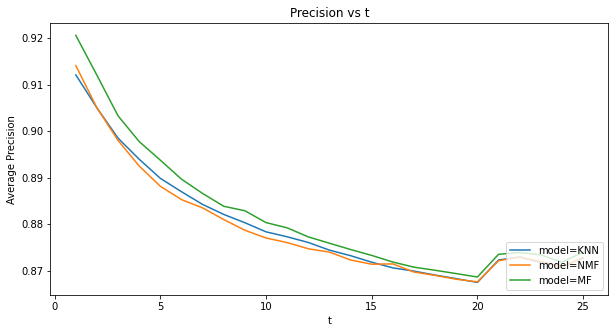

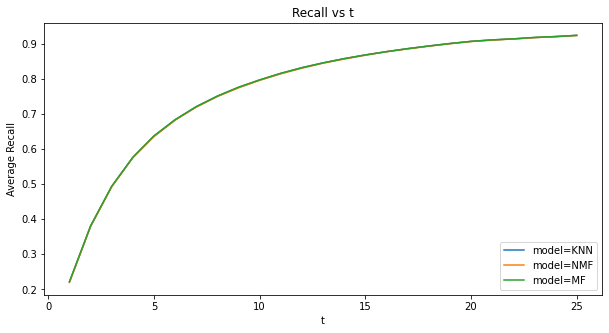

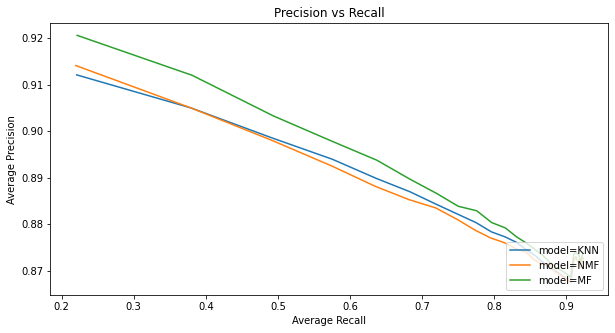

In [ ]:
#Precision vs t
plt.plot(t_list, precision_vs_t_allmodels[0], '-', label='model=KNN', markersize=10)
plt.plot(t_list, precision_vs_t_allmodels[1], '-', label='model=NMF', markersize=10)
plt.plot(t_list, precision_vs_t_allmodels[2], '-', label='model=MF', markersize=10)
plt.title('Precision vs t')
plt.xlabel('t')
plt.ylabel('Average Precision')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(10, 5)
plt.show()
#Recall vs t
plt.plot(t_list, recall_vs_t_allmodels[0], '-', label='model=KNN', markersize=10)
plt.plot(t_list, recall_vs_t_allmodels[1], '-', label='model=NMF', markersize=10)
plt.plot(t_list, recall_vs_t_allmodels[2], '-', label='model=MF', markersize=10)
plt.title('Recall vs t')
plt.xlabel('t')
plt.ylabel('Average Recall')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(10, 5)
plt.show()
#Precision vs Recall
plt.plot(recall_vs_t_allmodels[0], precision_vs_t_allmodels[0], '-', label='model=KNN', markersize=10)
plt.plot(recall_vs_t_allmodels[1], precision_vs_t_allmodels[1], '-', label='model=NMF', markersize=10)
plt.plot(recall_vs_t_allmodels[2], precision_vs_t_allmodels[2], '-', label='model=MF', markersize=10)
plt.title('Precision vs Recall')
plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(10, 5)
plt.show()

From each of the plots, the following observations are made: generally as t increases, average precision decreases and average recall increases for all 3 algorithms. Furthermore, average precision declines as average recall increases indicating an inverse relationship. Recall values were shown to all have almost similar values however, MF had the highest precision values with KNN and MF being similar. This concludes that using MF has the most relevance in recommending a set of movies to users with the highest chance of liking them. 